<a href="https://colab.research.google.com/github/SiddharthTiwarids23/project-1/blob/main/MKTA_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import files
uploaded = files.upload()

import io
import pandas as pd


file_name = "purchases (1).txt"
data = pd.read_csv(io.BytesIO(uploaded[file_name]), delimiter="\t", names=["Customer ID", "Bill Amount", "Transaction Date"])

Saving purchases (1).txt to purchases (1).txt


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis and RFM Calculation

In [ ]:
# Convert 'Transaction Date' to datetime
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])


In [ ]:
# Determine the end date for the dataset to calculate recency
end_date = data['Transaction Date'].max()


In [ ]:
# Calculate RFM metrics
rfm = data.groupby('Customer ID').agg({
    'Transaction Date': lambda x: (end_date - x.max()).days, # Recency
    'Customer ID': 'count',                                  # Frequency
    'Bill Amount': 'sum'                                     # Monetary
}).rename(columns={'Transaction Date': 'Recency', 'Customer ID': 'Frequency', 'Bill Amount': 'Monetary'})

In [ ]:
rfm

,Recency,Frequency,Monetary
Customer ID,,,
10,3828,1,30.0
80,342,7,500.0
90,757,10,1158.0
120,1400,1,20.0
130,2969,2,100.0
...,...,...,...
263820,0,1,10.0
263870,134,1,50.0
263880,33,1,20.0


# RFM Scoring and Managerial Segmentation

In [ ]:
# Function to assign scores based on breakpoints
def rfm_scoring(x, breakpoints, scores):
    for i, point in enumerate(breakpoints):
        if x <= point:
            return scores[i]
    return scores[-1]


In [ ]:
# Breakpoints for scoring
recency_breakpoints = rfm['Recency'].quantile([0.33, 0.66]).tolist()
frequency_breakpoints = rfm['Frequency'].quantile([0.66, 0.33]).tolist()
monetary_breakpoints = rfm['Monetary'].quantile([0.33, 0.66]).tolist()



In [ ]:
# Assign scores to each RFM component
rfm['R_Score'] = rfm['Recency'].apply(lambda x: rfm_scoring(x, recency_breakpoints, [3, 2, 1]))
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: rfm_scoring(x, frequency_breakpoints, [1, 2, 3]))
rfm['M_Score'] = rfm['Monetary'].apply(lambda x: rfm_scoring(x, monetary_breakpoints, [1, 2, 3]))

# Calculate combined RFM score
rfm['RFM_Score'] = rfm['R_Score'] * 100 + rfm['F_Score'] * 10 + rfm['M_Score']




In [ ]:
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
10,3828,1,30.0,1,1,1,111
80,342,7,500.0,3,3,3,333
90,757,10,1158.0,2,3,3,233
120,1400,1,20.0,2,1,1,211
130,2969,2,100.0,1,1,2,112
...,...,...,...,...,...,...,...
263820,0,1,10.0,3,1,1,311
263870,134,1,50.0,3,1,2,312
263880,33,1,20.0,3,1,1,311


In [ ]:
# Managerial segmentation
def categorize_customer(row):
    if row['Recency'] > 1095:
        return 'Inactive'
    elif 730 < row['Recency'] <= 1095:
        return 'Cold'
    elif 365 < row['Recency'] <= 730:
        if row['Monetary'] > 100:
            return 'Warm high value'
        else:
            return 'Warm low value'
    elif row['Recency'] <= 365:
        if row['First Purchase'] <= 365:
            if row['Monetary'] > 100:
                return 'New active high value'
            else:
                return 'New active low value'
        elif row['Monetary'] > 100:
            return 'Active high value'
        else:
            return 'Active low value'

# Calculate the 'First Purchase' for each customer
first_purchase = data.groupby('Customer ID')['Transaction Date'].min()
rfm = rfm.join(first_purchase.rename('First Purchase'))
rfm['First Purchase'] = first_purchase.apply(lambda x: (end_date - x).days)

# Apply the categorization function
rfm['Segment'] = rfm.apply(categorize_customer, axis=1)

# Calculate the number of unique segments in the segmentation
unique_segments = rfm['Segment'].unique()
number_of_segments= len(unique_segments)

print("Unique Segments:", unique_segments)
print("Number of Segments:", number_of_segments)


Unique Segments: ['Inactive' 'Active high value' 'Cold' 'Warm low value' 'Warm high value'
 'New active low value' 'Active low value' 'New active high value']
Number of Segments: 8


In [ ]:
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,First Purchase,Segment
Customer ID,,,,,,,,,
10,3828,1,30.0,1,1,1,111,3828,Inactive
80,342,7,500.0,3,3,3,333,3750,Active high value
90,757,10,1158.0,2,3,3,233,3782,Cold
120,1400,1,20.0,2,1,1,211,1400,Inactive
130,2969,2,100.0,1,1,2,112,3709,Inactive
...,...,...,...,...,...,...,...,...,...
263820,0,1,10.0,3,1,1,311,0,New active low value
263870,134,1,50.0,3,1,2,312,134,New active low value
263880,33,1,20.0,3,1,1,311,33,New active low value


RFM Scoring Function (rfm_scoring):

This function assigns scores to each of the RFM components (Recency, Frequency, Monetary) based on defined breakpoints.
The breakpoints argument contains the thresholds for scoring.
The scores argument holds the scores to be assigned.
The function iterates through each breakpoint: if the RFM value (x) is less than or equal to a breakpoint, it assigns the corresponding score. If the value exceeds all breakpoints, it assigns the last score in the list.
Determining Breakpoints:

recency_breakpoints, frequency_breakpoints, and monetary_breakpoints are lists that contain breakpoints for each RFM component.
These breakpoints are determined based on quantiles (33rd and 66th percentiles) of the respective RFM distributions.
For Recency, lower values are better, so the scores are assigned in descending order (3, 2, 1).
For Frequency and Monetary, higher values are better, so the scores are in ascending order (1, 2, 3).
Applying the Scoring Function:

The rfm_scoring function is applied to each RFM component in the dataset.
R_Score, F_Score, and M_Score are the scores assigned to Recency, Frequency, and Monetary values, respectively.
Calculating Combined RFM Score:

RFM_Score is calculated as a combined score from the individual R, F, and M scores.
It is computed by multiplying the R score by 100, the F score by 10, and adding the M score. This creates a unique three-digit number for each customer, representing their overall RFM classification.

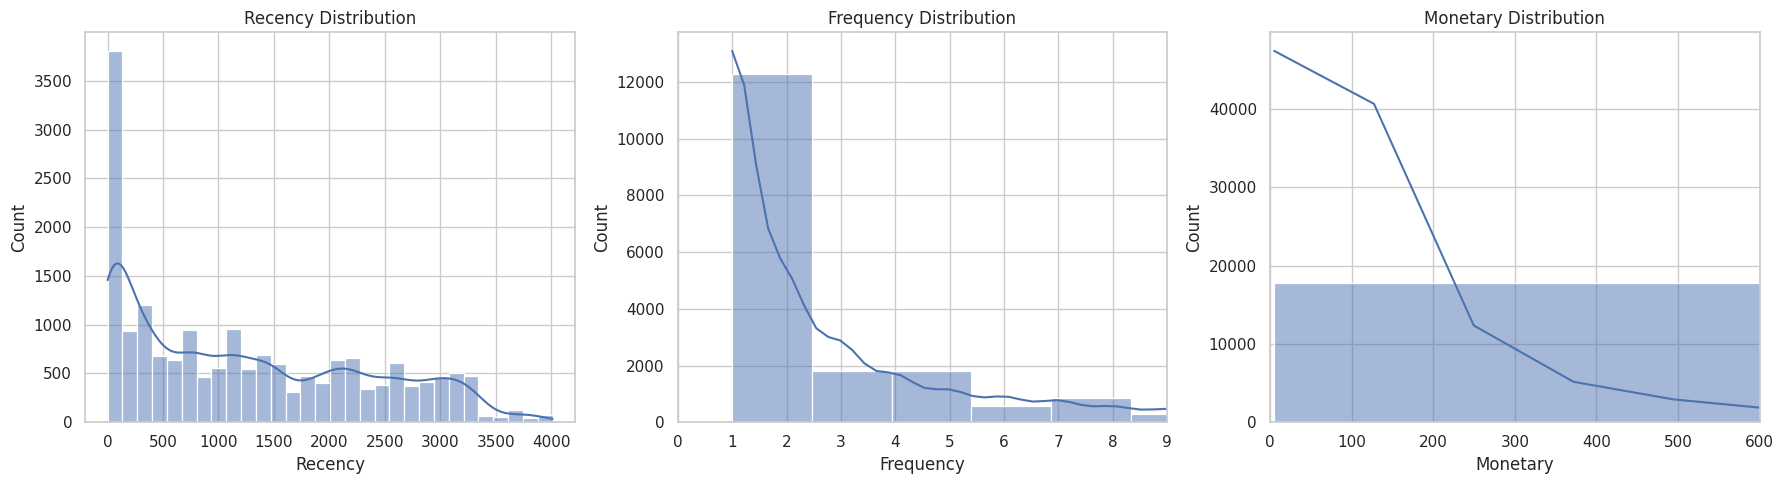

In [ ]:

sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

# Recency distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')

# Frequency distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')
plt.xlim(0, rfm['Frequency'].quantile(0.95))

# Monetary distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution')
plt.xlim(0, rfm['Monetary'].quantile(0.95))

plt.tight_layout()
plt.show()

High Frequency of Low Monetary Values: The high bars at the beginning of the histogram indicate that a large number of customers spend smaller amounts. This is typical for many retail businesses, where the majority of transactions are for lower-value purchases.

Tail of Higher Values: The line that remains at a relatively constant level and then tails off represents the count of customers that spend at progressively higher amounts. This tail suggests that as the spending amount increases, there are fewer customers who reach these higher spending levels.

Skewed Distribution: Retail spending data often follows a Pareto distribution (also known as the 80/20 rule), where a small percentage of customers account for a large percentage of sales. This distribution is not uniform; it's heavily weighted towards lower spend amounts.

Potential Data Display Issue: If the line appears constant throughout a large section of the graph before tailing off, it might also indicate a visualization scaling issue or data binning issue. This could happen if there are a few extremely high values (outliers) that stretch the x-axis, making the rest of the data appear compressed and seemingly constant.

# Segment Transition Analysis

In [ ]:
# Filter the dataset for transactions in 2014 and 2015
data_2014 = data[data['Transaction Date'].dt.year == 2014]
data_2015 = data[data['Transaction Date'].dt.year == 2015]


In [ ]:
# Function to calculate RFM for a given year's data
def calculate_rfm_corrected(data, end_date):
    rfm_year = data.groupby('Customer ID').agg({
        'Transaction Date': lambda x: (end_date - x.max()).days, # Recency
        'Customer ID': 'count',                                  # Frequency
        'Bill Amount': 'sum'                                     # Monetary
    }).rename(columns={'Transaction Date': 'Recency', 'Customer ID': 'Frequency', 'Bill Amount': 'Monetary'})

    first_purchase = data.groupby('Customer ID')['Transaction Date'].min()
    rfm_year = rfm_year.join(first_purchase.rename('First Purchase'))
    rfm_year['First Purchase'] = first_purchase.apply(lambda x: (end_date - x).days)

    # Apply the scoring and segmentation functions
    rfm_year['R_Score'] = rfm_year['Recency'].apply(lambda x: rfm_scoring(x, recency_breakpoints, [3, 2, 1]))
    rfm_year['F_Score'] = rfm_year['Frequency'].apply(lambda x: rfm_scoring(x, frequency_breakpoints, [1, 2, 3]))
    rfm_year['M_Score'] = rfm_year['Monetary'].apply(lambda x: rfm_scoring(x, monetary_breakpoints, [1, 2, 3]))
    rfm_year['RFM_Score'] = rfm_year['R_Score'] * 100 + rfm_year['F_Score'] * 10 + rfm_year['M_Score']
    rfm_year['Segment'] = rfm_year.apply(categorize_customer, axis=1)

    return rfm_year



In [ ]:
# Recalculate RFM for 2014 and 2015
rfm_2014 = calculate_rfm_corrected(data_2014, pd.to_datetime("2014-12-31"))
rfm_2015 = calculate_rfm_corrected(data_2015, pd.to_datetime("2015-12-31"))

# Identify customers present in both years
common_customers = rfm_2014.index.intersection(rfm_2015.index)



In [ ]:
common_customers

Int64Index([    80,    480,    830,    850,    860,   1150,   1310,   1420,
              1470,   1710,
            ...
            234490, 234510, 234520, 234530, 234540, 234560, 234590, 234640,
            234660, 234760],
           dtype='int64', name='Customer ID', length=2965)

In [ ]:
# Create a DataFrame for segment transition analysis
segment_transition = pd.DataFrame({
    'Segment_2014': rfm_2014.loc[common_customers, 'Segment'],
    'Segment_2015': rfm_2015.loc[common_customers, 'Segment']
})

# Calculate the transition counts
transition_counts = segment_transition.groupby(['Segment_2014', 'Segment_2015']).size().unstack(fill_value=0)

In [ ]:
transition_counts

Segment_2015,New active high value,New active low value
Segment_2014,,
New active high value,365,110
New active low value,159,2331


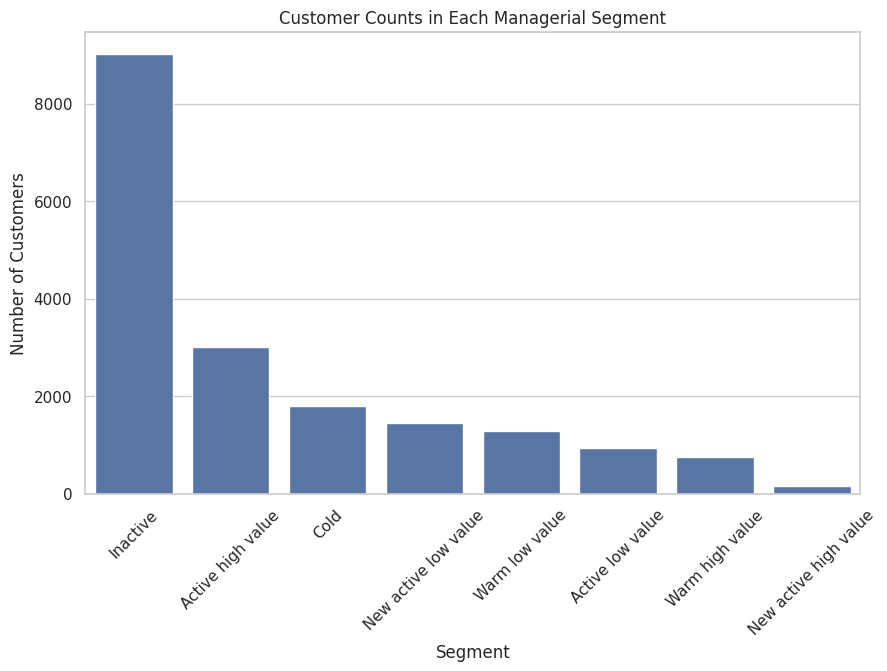

In [ ]:
segment_counts = rfm['Segment'].value_counts()

# Create a bar chart for Segmentation Counts
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title('Customer Counts in Each Managerial Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

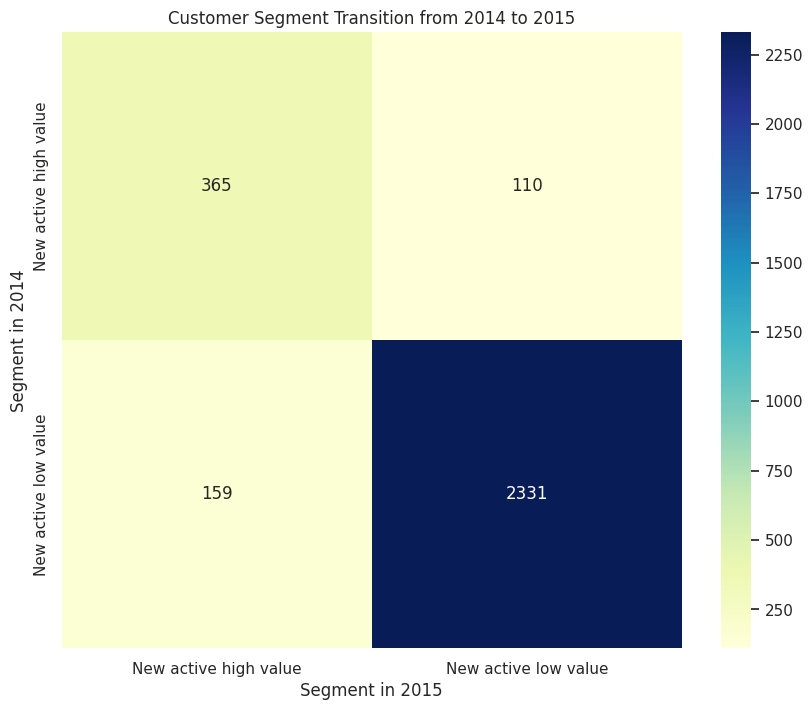

In [ ]:
# Create a heatmap for Segment Transition
plt.figure(figsize=(10, 8))
sns.heatmap(transition_counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Customer Segment Transition from 2014 to 2015')
plt.ylabel('Segment in 2014')
plt.xlabel('Segment in 2015')
plt.show()

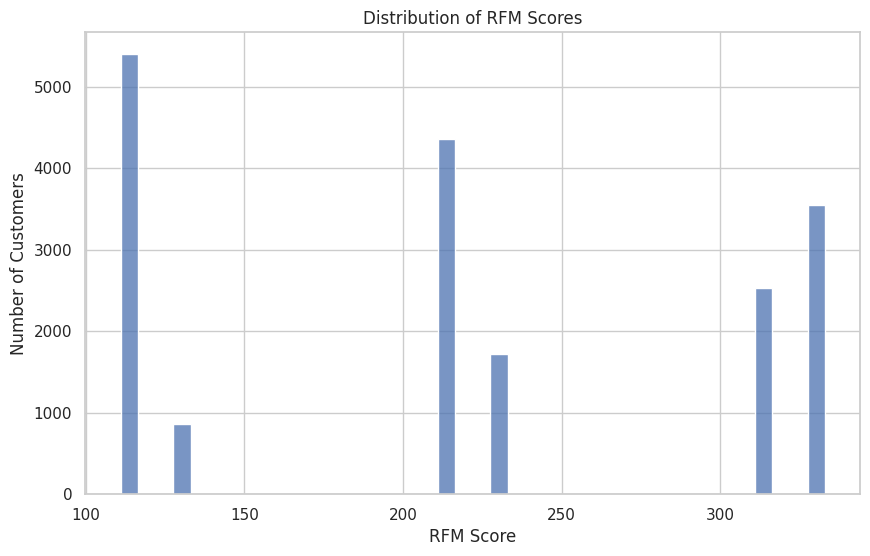

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm['RFM_Score'], bins=40, kde=False)
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.show()


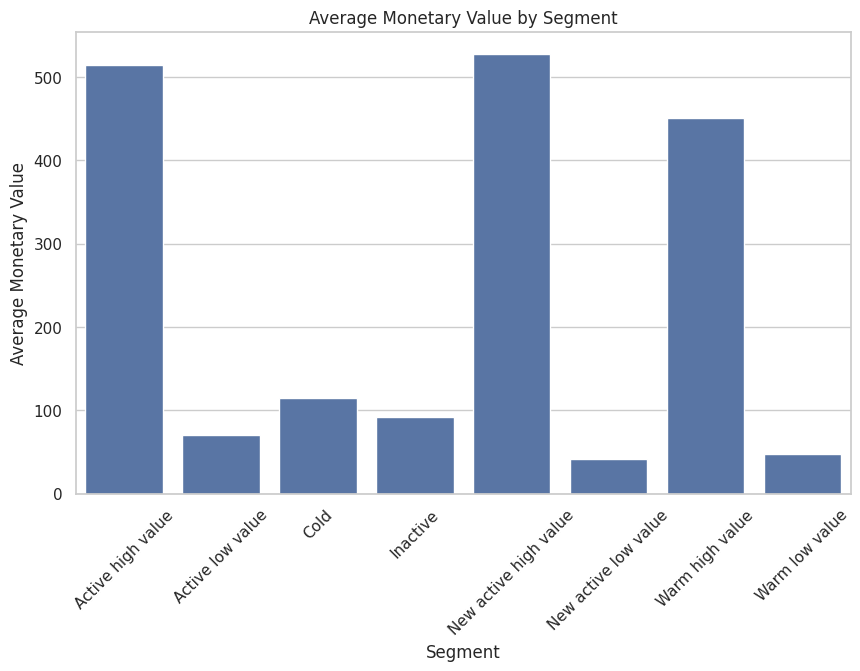

In [ ]:
avg_monetary_by_segment = rfm.groupby('Segment')['Monetary'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_monetary_by_segment.index, y=avg_monetary_by_segment.values)
plt.title('Average Monetary Value by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Monetary Value')
plt.xticks(rotation=45)
plt.show()


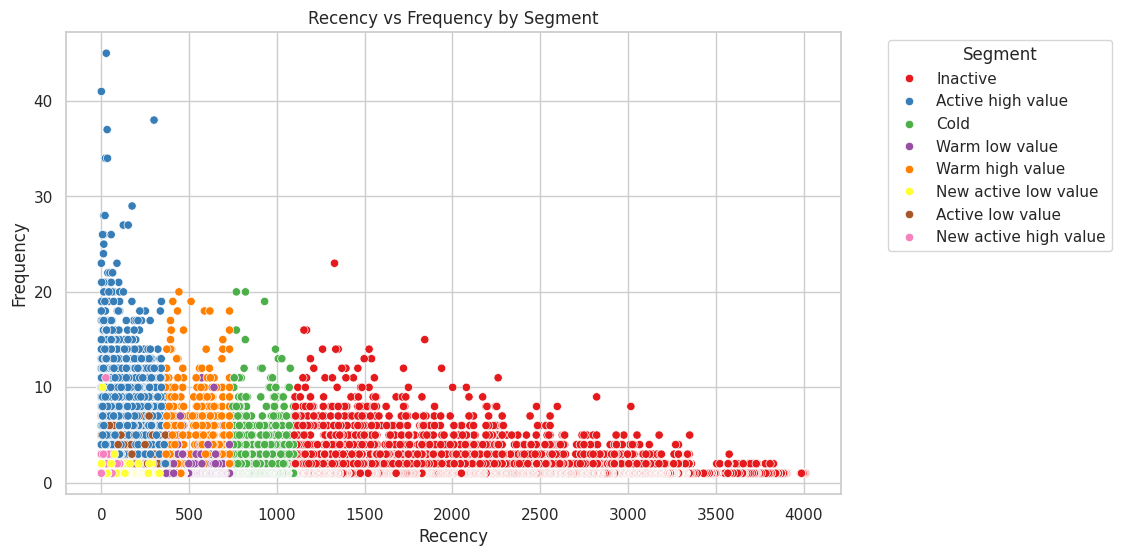

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=rfm, palette='Set1')
plt.title('Recency vs Frequency by Segment')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


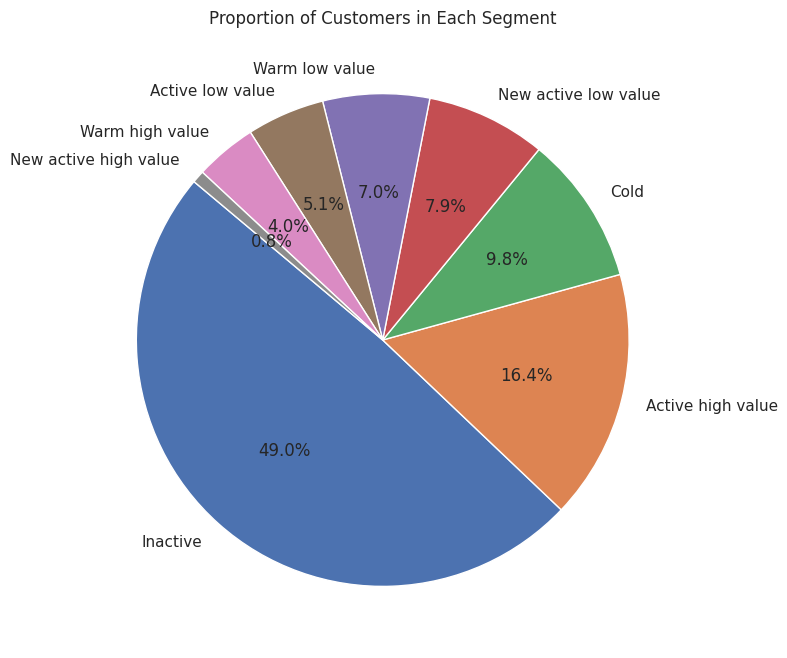

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Customers in Each Segment')
plt.show()


# Conclusion and Interpretations

Most Important Segments

Active High Value: Customers with recent purchases and high spending. This segment is crucial as it contributes significantly to the revenue and shows recent engagement.

Warm High Value: Customers who have not purchased as recently but have historically spent large amounts. They have potential for re-engagement and increased spending.

Marketing Actions

For Active High Value:

Loyalty Programs: Reward their loyalty and encourage continued engagement.

Exclusive Offers: Provide exclusive deals or early access to new products.

Personalization: Utilize their purchase history to offer personalized products and services.

For Warm High Value:

Re-engagement Campaigns: Target them with special offers to rekindle their interest.

Feedback and Surveys: Understand their inactivity reasons and preferences for tailored offerings.

Membership Benefits: Offer premium membership or benefits to incentivize them to become active again.


These segments are vital due to their proven value and engagement with the business. Focusing on them can lead to sustained and increased revenue.

In [ ]:
# Create a combined RFM segment code
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [ ]:
# Define a function to group segments
def group_segments(segment):
    if segment == '333':
        return 'Loyal High Spenders'
    elif segment[0] == '3' and (segment[1] in ['1', '2']) and (segment[2] in ['2', '3']):
        return 'New Enthusiasts'
    elif segment[0] == '1' and segment[1] == '3' and segment[2] == '3':
        return 'Sleeping Giants'
    elif segment[0] in ['2', '3'] and segment[1] == '1' and segment[2] in ['1', '2']:
        return 'Casual Shoppers'
    elif segment[0] == '1' and segment[1] in ['1', '2'] and segment[2] in ['2', '3']:
        return 'At Risk'
    elif segment == '111':
        return 'Lost Cheap'
    else:
        return 'Other'

# Apply the grouping function
rfm['Segment_Group'] = rfm['RFM_Segment'].apply(group_segments)


In [ ]:
# Count the number of customers in each segment
segment_counts = rfm['Segment_Group'].value_counts()

print(segment_counts)


Casual Shoppers        4931
Loyal High Spenders    3020
Lost Cheap             2989
Other                  2934
At Risk                2410
New Enthusiasts        1610
Sleeping Giants         523
Name: Segment_Group, dtype: int64


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
# Normalize the data
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=8, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Calculate the mean RFM values for each cluster
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = ['Recency', 'Frequency', 'Monetary'])
cluster_centers['Cluster'] = range(0,8)

# Inverse transform the normalized values to their original scale
cluster_centers[['Recency', 'Frequency', 'Monetary']] = scaler.inverse_transform(cluster_centers[['Recency', 'Frequency', 'Monetary']])

print(cluster_centers)


       Recency  Frequency      Monetary  Cluster
0   432.641747   5.205376    277.740029        0
1  1620.989130   1.764151     75.539504        1
2  2893.219494   1.327737     57.752135        2
3   502.163462   7.182692   3896.401731        3
4   361.894737   6.789474  11458.578947        4
5   273.346212   9.504545    554.858182        5
6   185.180000  18.580000    862.832333        6
7   382.027439   1.567253     80.604388        7


In [ ]:
# Calculate average RFM values for each cluster
cluster_avg = rfm.groupby('Cluster').mean()

# Display the average values
print(cluster_avg)


             Recency  Frequency      Monetary   R_Score   F_Score   M_Score  \
Cluster                                                                       
0         433.584312   5.203859    277.528947  2.643456  2.987416  2.874161   
1        1624.631126   1.761534     75.696047  1.549518  1.409268  1.778757   
2        2895.620724   1.326962     57.450646  1.000000  1.135815  1.526157   
3         502.163462   7.182692   3896.401731  2.576923  2.634615  3.000000   
4         361.894737   6.789474  11458.578947  2.736842  2.789474  3.000000   
5         273.346212   9.504545    554.858182  2.805303  3.000000  2.986364   
6         185.180000  18.580000    862.832333  2.873333  3.000000  3.000000   
7         383.230356   1.568105     80.606062  2.572400  1.327546  1.826741   

          RFM_Score  First Purchase  
Cluster                              
0        297.093960     2283.980285  
1        170.823252     2062.562231  
2        112.884306     3010.806338  
3        287.038462

<ipython-input-32-b4ce1e7f6be8>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_avg = rfm.groupby('Cluster').mean()


Engaged Potential Buyers (Cluster 0): These customers have made recent purchases, buy frequently, and spend a good amount. They show strong engagement and potential for growth.

Disengaged Low Spenders (Cluster 1): Customers in this group have not made purchases recently, are infrequent buyers, and spend less. They show signs of disengagement and are at risk of churning.

Dormant Customers (Cluster 2): This segment represents customers who have been inactive for a very long time, with lower spending and purchase frequency.

High Value Recent Customers (Cluster 3): Customers who have shopped not too long ago, with a decent purchase frequency and very high spending, indicating their high value.

Premium Customers (Cluster 4): This segment consists of customers who purchase quite frequently and spend significantly more than others, making them a premium segment.

Frequent Moderate Spenders (Cluster 5): Customers who are highly engaged, purchasing very frequently with high spending patterns.

Loyal Elite (Cluster 6): This group contains the most loyal and valuable customers, characterized by their extremely frequent purchases and very high spending.

Occasional Shoppers (Cluster 7): These customers make purchases occasionally with moderate spending and have the potential for increased engagement.

Engaged Potential Buyers (Cluster 0): These are customers with recent, frequent purchases and moderate spending, indicating strong current engagement and potential for further growth.

Disengaged Low Spenders (Cluster 1): This segment comprises customers who have been inactive recently, with low frequency and monetary figures, suggesting a risk of churning.

Dormant Customers (Cluster 2): These customers have not engaged with the business for a long time and generally exhibit low spending and purchase frequency.

High Value Recent Customers (Cluster 3): This group includes customers who have made recent purchases with a good frequency and have very high spending, indicating their high value to the business.

Premium Customers (Cluster 4): Customers in this segment are frequent shoppers with the highest spending, classifying them as the most premium and valuable customer base.

Frequent Moderate Spenders (Cluster 5): These are highly engaged customers who purchase frequently and spend a moderate amount, showing consistent patronage.

Loyal Elite (Cluster 6): This elite segment is characterized by customers who are extremely loyal, with very frequent purchases and high spending, making them central to the business.

Occasional Shoppers (Cluster 7): Customers in this segment shop sporadically with moderate expenditure, representing a segment with potential for increased engagement and value.